### Anomaly detection in Oklahoma purchase credit card transactions by unsupervised learning

### Author: Huizhe (Sunny) Zhu- hz2657

The Office of Management and Enterprise Services in the State of Oklahoma has made its [purchase credit card transactions](https://catalog.data.gov/dataset/purchase-card-pcard-fiscal-year-2014) available. This dataset contains information on purchases made through the purchase card programs administered by the state and higher education institutions. 


Tasks:

1. construct features

2. implement unsupervised learning models, to find isolated observations - anomalies

3. identify a small cluster to be labeled as suspicious, explain why the particular cluster(s) are anomalous

# 1. import data, EDA

In [159]:
import pandas as pd
df = pd.read_csv(r'purchase_credit_card.csv', encoding = "ISO-8859-1")    
df.head(2)  

,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC)
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,7/30/2013 0:00,7/31/2013 0:00,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,7/30/2013 0:00,7/31/2013 0:00,SHERATON


In [160]:
# the dataset has 442,458 rows and 11 columns 
print(df.shape)
# check column names
print(df.columns)

(442458, 11)
Index(['Year-Month', 'Agency Number', 'Agency Name', 'Cardholder Last Name',
       'Cardholder First Initial', 'Description', 'Amount', 'Vendor',
       'Transaction Date', 'Posted Date', 'Merchant Category Code (MCC)'],
      dtype='object')


In [161]:
# change column names 
df.columns = ['Year_Month', 'Agency_Number', 'Agency_Name', 'Cardholder_Last_Name',
      'Cardholder_First_Initial', 'Description', 'Amount', 'Vendor', 'Transaction_Date',
      'Posted_Date', 'Merchant_Category']
df.head(2)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,7/30/2013 0:00,7/31/2013 0:00,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,7/30/2013 0:00,7/31/2013 0:00,SHERATON


In [220]:
# 1. show transaction amount by agency name
# from the graph, we can see University of OKLAHOMA has the most transactions, with a number of 115.995K
import numpy as np
import plotly
import plotly.express as px

# Summarize the count statistics by agency_name in df_count
df_count = df['Agency_Name'].value_counts()
df_count = pd.DataFrame(df_count).reset_index()
df_count.columns = ['Agency_Name','Count']


fig = px.bar(df_count, x='Agency_Name', y='Count', color = 'Agency_Name', width=1000, height=400)
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
fig.show()

<Figure size 640x480 with 0 Axes>

In [162]:
# 2. Create timestamp
df['Transaction_Date'] = pd.to_datetime(df.Transaction_Date, format="%m/%d/%Y %H:%M") 

In [163]:
# 3. create "time" variable: days since last purchase 
df = df.sort_values(['Agency_Name', 'Transaction_Date'], ascending=[True, True])
df['time'] = df.Transaction_Date-df.Transaction_Date.shift(1)

In [164]:
# 4. for 'time' in the first record in an agency, we need to assign the value to 0 
df.groupby('Agency_Number').first()['time']=0


In [165]:
#df.iloc[3914]

# 2. Feature engineering: construct features 

A corporate card (agency_name) can be used by many cardholders and these cardholders have to follow the corporation policy (agency_names). So I aggregate to the Agency_Name level and card holder level first to build features.

The features are introduced by FRM principle. 

### Monetary: based on amount of money

###  Feature 1: Ratio of amount spend and average spending by agency and merchant category

Why the feature 'ratio_amount_by_agency_by_category' can identify anomalies: 

- if one transaction is significantly higher than the average transaction for that agency in that merchant category, then it indicates the abnormal behaviour, it is more likely to be an anomaly

In [166]:
# create average spending group by agency and merchant category 
stat_by_agency = df.groupby(['Agency_Name', 'Merchant_Category'])['Amount'].mean()
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['AVG_amount']
# add the new feature average spending to the dataset 
df2 = pd.merge(df, stat_by_agency, how='left', on=['Agency_Name', 'Merchant_Category'])
# Feature 1: ratio of amount spending and avergae spending by merchant category 
df2['ratio_amount_by_agency_by_category'] = df2.Amount / df2.AVG_amount
df2.head(2)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,time,AVG_amount,ratio_amount_by_agency_by_category
0,201307,60600,ARDMORE HIGHER EDUCATION CENTER,Ray,M,GENERAL PURCHASE,101.63,HOBBY-LOBBY #0113,2013-06-27,7/1/2013 0:00,"HOBBY,TOY,AND GAME STORES",NaT,148.770000,0.683135
1,201307,60600,ARDMORE HIGHER EDUCATION CENTER,Stoker,C,24/4 CAT 5E PLENUM 1000' P EA|ON-Q CAT 6 RJ45 ...,239.70,LOWES #01749,2013-07-10,7/11/2013 0:00,HOME SUPPLY WAREHOUSE STORES,13 days,110.559231,2.168069


In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
df4 = df2.copy()
df4.replace(np.inf, 1,inplace=True)
df4.replace(-np.inf, 1,inplace=True)

Text(0.5, 1.0, 'Ratio of spending by agency and merchant category')

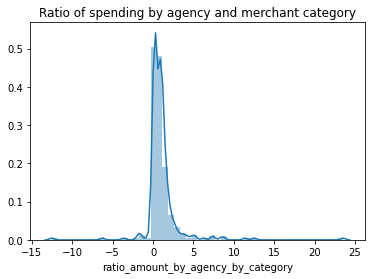

In [221]:
# visualization: Histogram:  x: row, y: ratio_amount_by_agency_by_category
sns.distplot(df4['ratio_amount_by_agency_by_category'][1:300]).set_title("Ratio of spending by agency and merchant category")    # This is seaborn


###  Feature 2: Ratio of amount spend and average spending by agency and transaction description

Why the feature 'ratio_amount_by_agency_by_Description' can identify anomalies: 

- similar to the first feature, a transaction is suspecious if the spending for one transaction is significantly higher than the averge for similar purposes(description). 

In [167]:
# create average spending group by agency and merchant category 
stat_by_Description = df.groupby(['Agency_Name', 'Description'])['Amount'].mean()
stat_by_Description = pd.DataFrame(stat_by_Description)
stat_by_Description.columns = ['AVG_amount_by_Description']

# add the new feature average spending to the dataset 
df2 = pd.merge(df2, stat_by_Description, how='left', on=['Agency_Name', 'Description'])

# Feature 2: ratio of amount spending and avergae spending by Description of transaction 
df2['ratio_amount_by_agency_by_Description'] = df2.Amount / df2.AVG_amount_by_Description
df2.head(2)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,time,AVG_amount,ratio_amount_by_agency_by_category,AVG_amount_by_Description,ratio_amount_by_agency_by_Description
0,201307,60600,ARDMORE HIGHER EDUCATION CENTER,Ray,M,GENERAL PURCHASE,101.63,HOBBY-LOBBY #0113,2013-06-27,7/1/2013 0:00,"HOBBY,TOY,AND GAME STORES",NaT,148.770000,0.683135,144.054516,0.705497
1,201307,60600,ARDMORE HIGHER EDUCATION CENTER,Stoker,C,24/4 CAT 5E PLENUM 1000' P EA|ON-Q CAT 6 RJ45 ...,239.70,LOWES #01749,2013-07-10,7/11/2013 0:00,HOME SUPPLY WAREHOUSE STORES,13 days,110.559231,2.168069,239.700000,1.000000


Text(0.5, 1.0, 'Ratio of spending by agency and description')

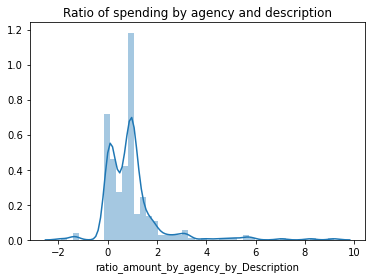

In [222]:
# visualization: Histogram:  x: row, y: ratio_amount_by_agency_by_category
df4 = df2.copy()
df4.replace(np.inf, 1,inplace=True)
df4.replace(-np.inf, 1,inplace=True)

sns.distplot(df4['ratio_amount_by_agency_by_Description'][1:300]).set_title("Ratio of spending by agency and description")    # This is seaborn

We can identify outliers from the boxplot for a selected agency, for example, is select Agency_Number as 26500, one significant outlier is within description 'COMPUTERS, COMPUTER EQUIPMENT, SOFTWARE' 

In [223]:
# data visualization 
df2_selected = df2.loc[df2['Agency_Number'] == 26500]

fig = px.box(df2_selected, x="Merchant_Category", y="ratio_amount_by_agency_by_Description",width=900, height=400, title = "Ratio of amount spend and average spending by description for transaction")
fig.show()

### on card holder level 

###  Feature 3: Ratio of amount spend and average spending by card holder

- ratio_amount_by_cardholder
- this feature is based on card holder level, to examine suspicious amount money for one transaction, to check if one transaction is significantly higher than what the card holder usually spend

In [168]:
# create average spending group by agency and merchant category 
stat_by_cardholder = df2.groupby(['Agency_Name', 'Cardholder_Last_Name'])['Amount'].mean()
stat_by_cardholder = pd.DataFrame(stat_by_cardholder)
stat_by_cardholder.columns = ['stat_by_cardholder']

# add the new feature average spending to the dataset 
df2 = pd.merge(df2, stat_by_cardholder, how='left', on=['Agency_Name', 'Cardholder_Last_Name'])

# Feature 2: ratio of amount spending and avergae spending by Description of transaction 
df2['ratio_amount_by_cardholder'] = df2.Amount / df2.stat_by_cardholder
df2.head(2)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,time,AVG_amount,ratio_amount_by_agency_by_category,AVG_amount_by_Description,ratio_amount_by_agency_by_Description,stat_by_cardholder,ratio_amount_by_cardholder
0,201307,60600,ARDMORE HIGHER EDUCATION CENTER,Ray,M,GENERAL PURCHASE,101.63,HOBBY-LOBBY #0113,2013-06-27,7/1/2013 0:00,"HOBBY,TOY,AND GAME STORES",NaT,148.770000,0.683135,144.054516,0.705497,91.013667,1.116645
1,201307,60600,ARDMORE HIGHER EDUCATION CENTER,Stoker,C,24/4 CAT 5E PLENUM 1000' P EA|ON-Q CAT 6 RJ45 ...,239.70,LOWES #01749,2013-07-10,7/11/2013 0:00,HOME SUPPLY WAREHOUSE STORES,13 days,110.559231,2.168069,239.700000,1.000000,124.961154,1.918196


In [ ]:
df4 = df2.copy()
df4.replace(np.inf, 1,inplace=True)
df4.replace(-np.inf, 1,inplace=True)

Text(0.5, 1.0, 'Ratio of spending by agency and cardholder level')

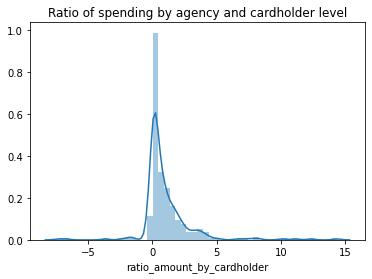

In [224]:
# visualization: Histogram:  x: row, y: ratio_amount_by_agency_by_category
sns.distplot(df4['ratio_amount_by_cardholder'][1:300]).set_title("Ratio of spending by agency and cardholder level")    # This is seaborn

### Based on Recency: time

###  Feature 4: ratio of time since last purchase / average time spend

- Ratio_AVG_time_since_lastP

In [169]:
# create new feature:average time spend since last purchase per month 
AVG_time_since_lastP = df2.groupby(['Agency_Name'])['time'].sum()/ df2.groupby(['Agency_Name'])['time'].count()
AVG_time_since_lastP = pd.DataFrame(AVG_time_since_lastP)
AVG_time_since_lastP.columns = ['AVG_time_since_lastP']

# add the new feature average spending to the dataset 
df2 = pd.merge(df2, AVG_time_since_lastP, how='left', on=['Agency_Name'])
df2['Ratio_AVG_time_since_lastP']=df2.time/df2.AVG_time_since_lastP

df2.head(2)

C:\Users\Huizhe ZHU\Anaconda3\lib\site-packages\pandas\core\arrays\timedeltas.py:597: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\Huizhe ZHU\Anaconda3\lib\site-packages\pandas\core\arrays\timedeltas.py:597: RuntimeWarning:

invalid value encountered in true_divide



,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,time,AVG_amount,ratio_amount_by_agency_by_category,AVG_amount_by_Description,ratio_amount_by_agency_by_Description,stat_by_cardholder,ratio_amount_by_cardholder,AVG_time_since_lastP,Ratio_AVG_time_since_lastP
0,201307,60600,ARDMORE HIGHER EDUCATION CENTER,Ray,M,GENERAL PURCHASE,101.63,HOBBY-LOBBY #0113,2013-06-27,7/1/2013 0:00,"HOBBY,TOY,AND GAME STORES",NaT,148.770000,0.683135,144.054516,0.705497,91.013667,1.116645,3 days 14:53:47.586206,NaN
1,201307,60600,ARDMORE HIGHER EDUCATION CENTER,Stoker,C,24/4 CAT 5E PLENUM 1000' P EA|ON-Q CAT 6 RJ45 ...,239.70,LOWES #01749,2013-07-10,7/11/2013 0:00,HOME SUPPLY WAREHOUSE STORES,13 days,110.559231,2.168069,239.700000,1.000000,124.961154,1.918196,3 days 14:53:47.586206,3.590476


In [170]:
# df2.groupby(['Agency_Name'])['time'].count()['COMM. OF THE LAND OFFICE']

In [96]:
# discover why -inf exists 
# df2.index[np.isinf(df2.Ratio_AVG_time_since_lastP)]

In [102]:
# discover why -inf exists: AVG_time_since_lastP is 0 
# df2.loc[3914:4237,].describe()

C:\Users\Huizhe ZHU\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3942: RuntimeWarning:

invalid value encountered in multiply



,Year_Month,Agency_Number,Amount,time,AVG_amount,ratio_amount_by_agency_by_category,AVG_amount_by_Description,ratio_amount_by_agency_by_Description,stat_by_cardholder,ratio_amount_by_cardholder,AVG_time_since_lastP,Ratio_AVG_time_since_lastP
count,324.000000,324.0,324.000000,324,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324,99.0
mean,201335.191358,63500.0,204.805648,-1 days +12:57:46.666666,216.611007,NaN,225.660666,0.924220,219.955362,0.936361,0 days 00:00:00,NaN
std,41.216341,0.0,399.521689,20 days 03:19:58.693284,212.495559,NaN,190.153924,1.626629,87.759872,1.618763,0 days 00:00:00,NaN
min,201307.000000,63500.0,-512.940000,-361 days +00:00:00,0.000000,-inf,7.000000,-2.993346,102.280690,-5.015023,0 days 00:00:00,-inf
25%,201309.000000,63500.0,21.952500,0 days 00:00:00,81.947500,0.302373,169.576139,0.147105,140.116383,0.128232,0 days 00:00:00,inf
50%,201311.000000,63500.0,83.000000,0 days 00:00:00,202.975417,0.817833,191.594757,0.428267,194.959194,0.409081,0 days 00:00:00,NaN
75%,201401.000000,63500.0,248.250000,1 days 00:00:00,262.034471,1.064630,278.634609,1.000000,341.035476,1.226796,0 days 00:00:00,inf
max,201401.000000,63500.0,3898.000000,10 days 00:00:00,1398.380000,inf,2194.730000,14.871493,348.960714,11.170312,0 days 00:00:00,inf


In [ ]:
df4 = df2.copy()
df4.replace(np.inf, 1,inplace=True)
df4.replace(-np.inf, 1,inplace=True)

Text(0.5, 1.0, 'Ratio of time purchase since last purchase and average time spend')

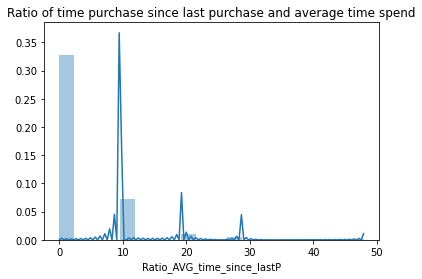

In [225]:
# visualization: Histogram:  x: row, y: ratio_amount_by_agency_by_category
sns.distplot(df4['Ratio_AVG_time_since_lastP'][69:500]).set_title("Ratio of time purchase since last purchase and average time spend")    # This is seaborn

###  on card holder level 

###  Feature 5: ratio of time / average time spend since last transactions by card holder 

- Ratio_AVG_time_since_lastP_by_cardholder
- the situation can be considered abnormal if one card holder took significant less time in transactions than he/she ususally do

In [173]:
# 4. for 'time' in the first record in an agency, we need to assign the value to 0 
# df['time']

In [174]:
# create new feature:average time spend since last purchase per month 
AVG_time_since_lastP_by_cardholder  = df2.groupby(['Agency_Name', 'Cardholder_Last_Name'])['time'].sum()/ df2.groupby(['Agency_Name','Cardholder_Last_Name'])['time'].count()
AVG_time_since_lastP_by_cardholder = pd.DataFrame(AVG_time_since_lastP_by_cardholder)
AVG_time_since_lastP_by_cardholder.columns = ['AVG_time_since_lastP_by_cardholder']

# add the new feature average spending to the dataset 
df2 = pd.merge(df2, AVG_time_since_lastP_by_cardholder, how='left', on=['Agency_Name','Cardholder_Last_Name'])

df2['Ratio_AVG_time_since_lastP_by_cardholder']= df2.time/df2.AVG_time_since_lastP_by_cardholder
df2.head(2)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,...,AVG_amount,ratio_amount_by_agency_by_category,AVG_amount_by_Description,ratio_amount_by_agency_by_Description,stat_by_cardholder,ratio_amount_by_cardholder,AVG_time_since_lastP,Ratio_AVG_time_since_lastP,AVG_time_since_lastP_by_cardholder,Ratio_AVG_time_since_lastP_by_cardholder
0,201307,60600,ARDMORE HIGHER EDUCATION CENTER,Ray,M,GENERAL PURCHASE,101.63,HOBBY-LOBBY #0113,2013-06-27,7/1/2013 0:00,...,148.770000,0.683135,144.054516,0.705497,91.013667,1.116645,3 days 14:53:47.586206,NaN,3 days 12:24:49.655172,NaN
1,201307,60600,ARDMORE HIGHER EDUCATION CENTER,Stoker,C,24/4 CAT 5E PLENUM 1000' P EA|ON-Q CAT 6 RJ45 ...,239.70,LOWES #01749,2013-07-10,7/11/2013 0:00,...,110.559231,2.168069,239.700000,1.000000,124.961154,1.918196,3 days 14:53:47.586206,3.590476,4 days 00:55:23.076923,3.219048


Text(0.5, 1.0, 'Ratio of AVG time since last purchase by cardholder')

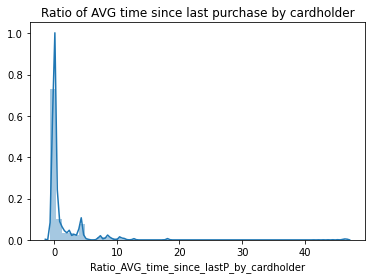

In [226]:
# visualization: Histogram:  x: row, y: ratio_amount_by_agency_by_category
df4 = df2.copy()
df4.replace(np.inf, 1,inplace=True)
df4.replace(-np.inf, 1,inplace=True)

sns.distplot(df4['Ratio_AVG_time_since_lastP_by_cardholder'][1:300]).set_title("Ratio of AVG time since last purchase by cardholder")    # This is seaborn

# 3. Dimension reduction

### 3.1  Principal Component Analysis (PCA)

#### 3.1.1 deal with na values in features
why there are na values: 
- for the first record of purchase, time since last transaction is na 

In [175]:
# deal with na values in features
# store features in df3

# we can modify features in df3
import numpy as np
df3 = df2.loc[:, ['ratio_amount_by_agency_by_category', 
                  'ratio_amount_by_agency_by_Description',
                   'ratio_amount_by_cardholder',  
                  'Ratio_AVG_time_since_lastP',  
                  #'Ratio_AVG_time_since_lastP_by_category',
                  #'Ratio_AVG_time_since_lastP_by_description', 
                  'Ratio_AVG_time_since_lastP_by_cardholder'
                 ]]

In [176]:
df3.isnull().sum()

ratio_amount_by_agency_by_category               0
ratio_amount_by_agency_by_Description            0
ratio_amount_by_cardholder                       0
Ratio_AVG_time_since_lastP                   10779
Ratio_AVG_time_since_lastP_by_cardholder    115340
dtype: int64

In [177]:
df3.describe()

,ratio_amount_by_agency_by_category,ratio_amount_by_agency_by_Description,ratio_amount_by_cardholder,Ratio_AVG_time_since_lastP,Ratio_AVG_time_since_lastP_by_cardholder
count,4.424580e+05,4.424580e+05,4.424580e+05,431679.0,327118.000000
mean,NaN,NaN,NaN,NaN,1.000000
std,NaN,NaN,NaN,NaN,154.791894
min,-inf,-inf,-inf,-inf,-56835.000000
25%,1.772695e-01,1.622273e-01,1.334946e-01,0.0,0.000000
50%,5.155666e-01,7.464374e-01,4.235956e-01,0.0,0.000000
75%,1.103523e+00,1.000000e+00,1.166465e+00,0.0,0.000000
max,inf,inf,inf,inf,49776.000000


In [178]:
# we can treat the na as something, why there are na: cuz time 
# replace na with 1: ratio = 1, no specific meaning
df3.replace(np.nan, 1,inplace=True)

#### 3.1.2 deal with inf values in features

why there are inf values?
- if Denominator is 0, then the ratio is infinite 
- that means the agency has never purchased  in a description or category, we should replace it to 1 (means normal), or na (means missing data)

In [179]:
np.isinf(df3.ratio_amount_by_agency_by_category).describe()

count     442458
unique         2
top        False
freq      442355
Name: ratio_amount_by_agency_by_category, dtype: object

In [180]:
# infinite values in ratio_amount_by_agency_by_category: 103
df3.index[np.isinf(df3.ratio_amount_by_agency_by_category)]

Int64Index([  3288,   3289,   4007,   4032,   4559,   4615,   9070,   9263,
             10350,  10552,
            ...
            299082, 299141, 299803, 299805, 300261, 300263, 440499, 440504,
            441474, 441475],
           dtype='int64', length=103)

In [181]:
# infinite values in ratio_amount_by_agency_by_Description: 555
df3.index[np.isinf(df3.ratio_amount_by_agency_by_Description)]

Int64Index([   729,    733,   3594,   3618,   3835,   3849,   8651,   8658,
              8663,   8673,
            ...
            427468, 428480, 429198, 430962, 435306, 435955, 435956, 436156,
            436379, 437772],
           dtype='int64', length=555)

In [20]:
# we discovered, if Denominator is 0, then the ratio is infinite 
# for ratio_amount_by_agency_by_category, the average amount of agency in that category is 0, so the ratio is infinite
# df2.iloc[3288,]

In [182]:
# replace inf and -inf with 1
df3.replace(np.inf, 1,inplace=True)
df3.replace(-np.inf, 1,inplace=True)

In [183]:
# summary statistics of df3 
df3.describe()

,ratio_amount_by_agency_by_category,ratio_amount_by_agency_by_Description,ratio_amount_by_cardholder,Ratio_AVG_time_since_lastP,Ratio_AVG_time_since_lastP_by_cardholder
count,4.424580e+05,4.424580e+05,442458.000000,4.424580e+05,442458.000000
mean,9.998813e-01,9.994244e-01,1.000000,1.000000e+00,1.000000
std,3.812034e+14,1.830668e+14,1.996128,2.726796e+04,133.095765
min,-9.309316e+16,-6.275203e+16,-66.279236,-1.089219e+07,-56835.000000
25%,1.773386e-01,1.632331e-01,0.133528,0.000000e+00,0.000000
50%,5.157935e-01,7.479934e-01,0.423639,-0.000000e+00,0.000000
75%,1.102968e+00,1.000000e+00,1.166333,0.000000e+00,1.000000
max,9.309316e+16,6.275203e+16,126.364202,5.804930e+06,49776.000000


In [185]:
# df3

#### 3.1.3 Standardization

In [186]:
# Standardization
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data to have a mean of 0 and a variance of 1
X_std = StandardScaler().fit_transform(df3)

In [26]:
# store Standardized features to "Standardized features.csv"
# X_std = pd.DataFrame(X_std, columns = ['ratio_amount_by_agency_by_category', 
#                  'ratio_amount_by_agency_by_Description',
#                   'ratio_amount_by_cardholder',  
#                  'Ratio_AVG_time_since_lastP',  
#                  'Ratio_AVG_time_since_lastP_by_category',
#                  'Ratio_AVG_time_since_lastP_by_description', 
#                  'Ratio_AVG_time_since_lastP_by_cardholder'])
# X_std.to_csv(r'Standardized features.csv')

#### 3.1.4 Create PCA instance

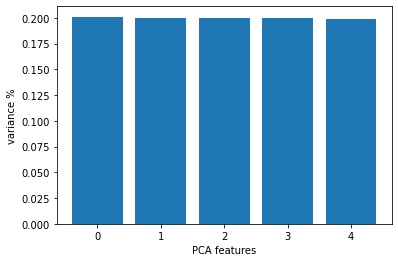

In [187]:
# Create a PCA instance: pca
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X_std)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Text(0, 0.5, 'cummulative explained variance')

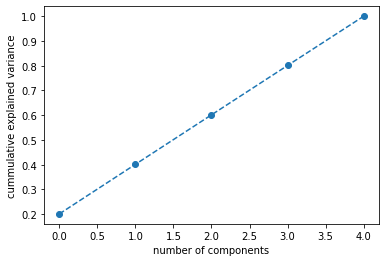

In [188]:
#plt.figure(gigsize = (10,8))
plt.plot(pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.xlabel('number of components')
plt.ylabel('cummulative explained variance')

Summary: we should use all components 

- 4 component accounts for 80% total variance
- 5 components accounts for 100% total variance

# 4. KNN

- PyOD:  Python Outlier Detection (PyOD) module collects a wide range of techniques ranging from supervised learning to unsupervised learning techniques. 

## 4.1 default K


### 4.1.1 Build model

- we use the standardized data: X_std
- outlier score is defined by distance, choose the shortest distance to the nearest neighbor

- **The unsupervised KNN does not have any learning involved, i.e., there are no parameters we can tune to make the performance better. **

In [189]:
# split into train and test dataset
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X_std, test_size=0.5)
X_train.shape
X_test.shape

(221229, 5)

In [190]:
# train kNN detector
from pyod.models.knn import KNN
clf_name = 'KNN'

#  training for the k-NN model and stores the model as clf.
clf = KNN()
clf.fit(X_train)

# predictions of the training data:
y_train_scores = clf.decision_scores_

In [191]:
# apply model to test data to get the predictions
y_test_pred = clf.predict(X_test) # outlier labels (0 or 1)

# count how many '0' and '1', There are 199242 '0's and 21987 '1's.
unique, counts = np.unique(y_test_pred, return_counts=True)
dict(zip(unique, counts))

# generate anomaly score using clf.decision_function:
y_test_scores = clf.decision_function(X_test)

In [42]:
# anomaly score
y_test_scores[1:10]

array([2.46760908e-02, 5.64535845e-05, 7.10606460e-05, 7.84470198e-05,
       6.31629373e-05, 1.58232616e-05, 1.23062885e-03, 0.00000000e+00,
       1.90936810e-03])

### 4.1.2 Determine boundary

- from the graph, we set boundary to be 0.05

In [192]:
# reshape, -1 simply means that it is an unknown dimension and we want numpy to figure it out
y_test_scores.reshape(-1, 1)

array([[1.15366343e-05],
       [3.84253773e-05],
       [4.20312768e-06],
       ...,
       [2.16070864e-06],
       [3.95438210e-05],
       [2.69062736e-04]])

In [193]:
from pyod.utils.utility import standardizer
y_test_scores_norm = standardizer(y_test_scores.reshape(-1, 1))

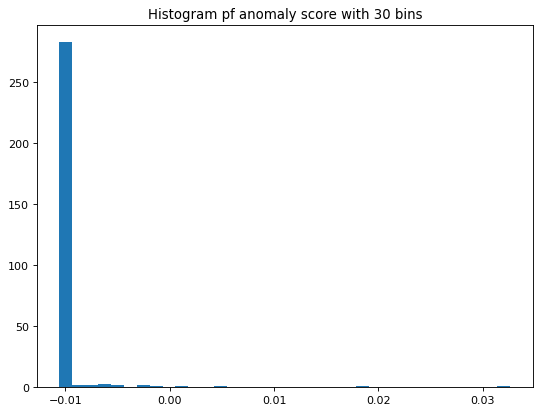

In [194]:
# plot anomaly score, observe which data points have the largest distance
# BECAUSE THERE ARE MORE 0 THAN OUTLIERS, SO AS THE NUMBER OF OBSERVATIONS INCREASE, WE ARE LESS LIKELY TO SEE OUTLIERS FROM THE GRAPH
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(y_test_scores_norm[1:300], bins=35)  # arguments are passed to np.histogram
plt.title("Histogram pf anomaly score with 30 bins")
plt.show()

### 4.1.3 Present summary statistics 

In [206]:
# Let's see how many '0's and '1's. We get 452 '0's and 48 '1's.
df_test = pd.DataFrame(X_test)
df_test.columns = ['ratio_amount_by_agency_by_category', 
                  'ratio_amount_by_agency_by_Description',
                   'ratio_amount_by_cardholder',  
                  'Ratio_AVG_time_since_lastP',  
                  'Ratio_AVG_time_since_lastP_by_cardholder']
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<0.05, 0, 1)

In [207]:
# there are 217356 '0', and 3873 '1'
df_test['cluster'].value_counts()

0    218715
1      2514
Name: cluster, dtype: int64

In [208]:
# 1.7% outliers 
2514/X_test.shape[0]

0.01136379046146753

In [209]:
# Now let's show the summary statistics:
df_test.groupby('cluster').mean()

,ratio_amount_by_agency_by_category,ratio_amount_by_agency_by_Description,ratio_amount_by_cardholder,Ratio_AVG_time_since_lastP,Ratio_AVG_time_since_lastP_by_cardholder,score
cluster,,,,,,
0,-4.969423e-18,-1.892175e-17,-0.012551,0.000824,-0.004122,0.000867
1,-1.566863e-01,-3.153452e-01,1.042338,0.081100,0.286503,1.717595


## 4.2 try different parameters: k_list = [20, 30, 40, 50]


### 4.2.1 Build model

In [200]:
#from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer

# Test a range of k-neighbors from 10 to 200. There will be 20 k-NN models.
k_list = [20, 30, 40, 50]
n_clf = 4

# Just prepare data frames so we can store the model results
# train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])
# train_scores.shape

# Modeling
for i in range(n_clf):
    k = k_list[i]
    clf = KNN(n_neighbors=k, method='largest')
    clf.fit(X_train)

    # Store the results in each column:
    #train_scores[:, i] = clf.decision_scores_
    test_scores[:, i] = clf.decision_function(X_test) 
# Decision scores have to be normalized before combination
test_scores_norm = standardizer(test_scores)

### 4.2.2 Determine boundary

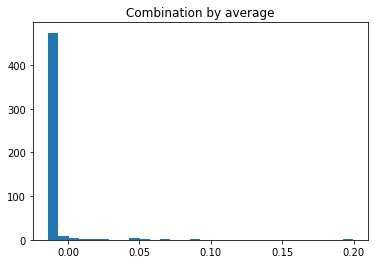

In [217]:
# Method 1: Average
# Combination by average
# The test_scores_norm is 500 x 20. The "average" function will take the average of the 20 columns. The result "y_by_average" is a single column: 
y_by_average = (test_scores_norm.mean(axis=1))
import matplotlib.pyplot as plt
plt.hist(y_by_average[500:1000], bins=30) # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [218]:
# When we use the average method, we get 1007 data points that have the outlier scores higher than 0. 
df_test = pd.DataFrame(X_test)
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']<0.05, 0, 1)
df_test['y_by_average_cluster'].value_counts()

0    218799
1      2430
Name: y_by_average_cluster, dtype: int64

In [219]:
# 1% outliers 
2430/df_test.shape[0]

0.010984093405475775

### 4.2.3 Present summary statistics 

In [214]:
df_test.columns = ['ratio_amount_by_agency_by_category', 
                  'ratio_amount_by_agency_by_Description',
                   'ratio_amount_by_cardholder',  
                  'Ratio_AVG_time_since_lastP',  
                  'Ratio_AVG_time_since_lastP_by_cardholder', 
                   'mean_by_average', 
                   'cluster']

df_test.groupby('cluster').mean()

,ratio_amount_by_agency_by_category,ratio_amount_by_agency_by_Description,ratio_amount_by_cardholder,Ratio_AVG_time_since_lastP,Ratio_AVG_time_since_lastP_by_cardholder,mean_by_average
cluster,,,,,,
0,-7.402298e-18,-3.448868e-17,-0.013641,0.001230,-0.003670,-0.012196
1,-2.677833e-01,-5.389380e-01,1.953092,0.077288,0.425154,1.821962


# 5. Summary

1% outliers are distinguished when we set the boundary to be 0.05.

The outliers have higher spending compared with average level, and more time since last purchase compared with the average level.  It distinguishes the transactions that happen less frequent than usual and have higher spending. They are suspicious and thus require further investigation. 